In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
!mkdir /content/drive/MyDrive/langgraph-code-assistant/

In [35]:
!wget http://www.comp.nus.edu.sg/~release/codeflaws/codeflaws.tar.gz
!cp /content/codeflaws.tar.gz   /content/drive/MyDrive/langgraph-code-assistant/

In [6]:
!tar xf ./codeflaws.tar.gz

In [7]:
from IPython.display import clear_output
!pip install -U langchain langchain_openai langgraph langchain_community
clear_output()

In [8]:
!git clone https://github.com/Suresoft-GLaDOS/SBFL
%cd SBFL
!pip install -r requirements.txt
!pip install setuptools
!python setup.py install
%cd ../
clear_output()

In [9]:
import SBFL.sbfl.utils as sbfl_utils
import SBFL.sbfl.base as sbfl_base

In [10]:
import numpy as np
if __name__ == "__main__":
    """
    X: coverage data
    y: test results
    """
    X = np.array([
        [1,0,1], # coverage of test t0
        [1,0,1], # coverage of test t1
        [1,1,1]  # coverage of test t2
    ], dtype=bool)

    y = np.array([
        0, # t0: PASS
        0, # t1: FAIL
        0  # t2: PASS
    ], dtype=bool)

    """
    Calculate the suspiciousness scores
    """
    sbfl = sbfl_base.SBFL(formula='Ochiai')
    print(sbfl.fit_predict(X, y))

[1.         0.57735027 1.        ]


In [11]:
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

from IPython.display import clear_output
from pprint import pprint
import collections
import subprocess
import itertools
import shutil
import random
import json
import uuid
import tqdm
import glob
import time
import os
import re

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3553: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [37]:
APPLY_SBFL = False
WITHOUT_TESTCASES_EXEC = True
COUNT_RETRY_OPENROUTER = 3
# LLM_MODEL_NAME = "meta-llama/open-router-llama-3.1-70b-instruct:free"
# LLM_MODEL_NAME = "meta-llama/open-router-llama-3.2-90b-vision-instruct:free"
LLM_MODEL_NAME = "meta-llama/open-router-llama-3.1-405b-instruct:free"
LLM_MODEL_NAME = (LLM_MODEL_NAME) + ("-with-sbfl" if APPLY_SBFL else "")


LLM_MODEL_NAME_SPLIT = LLM_MODEL_NAME.split('/')[-1]
STORE_GRAPH_IN_MEMORY = False
USE_OLLAMA = True
RUN_ON_COLAB = True
RUN_ON_KAGGLE = False
RUN_ON_WINDOWS = False
CHECK_BEFORE_ASK = True
if RUN_ON_KAGGLE:
    PATH_FOR_RUNNING = '/kaggle/working'
elif RUN_ON_COLAB:
    PATH_FOR_RUNNING = '/content/drive/MyDrive/langgraph-code-assistant'
else:
    PATH_FOR_RUNNING = '.'

print(LLM_MODEL_NAME)
print(LLM_MODEL_NAME_SPLIT)

meta-llama/open-router-llama-3.1-405b-instruct:free
open-router-llama-3.1-405b-instruct:free


In [38]:
from typing import Dict, TypedDict, Optional, List, Set
from langgraph.graph import END, StateGraph, START
try:
    from langgraph.checkpoint.sqlite import SqliteSaver
except Exception as e:
    print(e)
    pass
from langgraph.graph import StateGraph


class GraphState(TypedDict):
    llm_model_name: Optional[str]
    code_file_path: Optional[str]
    test_case_paths: List[str]
    fail_test_cases: List[dict]
    pass_test_cases: List[dict]
    log_execution: Set[str]
    code_have_error: Optional[bool]
    next_node: Optional[str]
    max_try_count: Optional[int]
    try_count: Optional[int]
    messages: List[tuple]
    initial_failed_test_cases_count: Optional[int]
    list_failed_test_cases_count: List[int]
    initial_code_have_error: Optional[bool]
    generated_code: Optional[str]
    llm_tokens: Optional[int]
    apply_sbfl: Optional[bool]
    sbfl_formula: Optional[str]
    sbfl_likelihood: Optional[float]
    sbfl_result: Optional[str]

No module named 'langgraph.checkpoint.sqlite'


In [39]:
def read_specific_file(path):
    with open(path, 'r', encoding='utf-8') as f:
        content_file = f.read()
    return content_file


def write_specific_file(path, content):
    with open(path, 'w') as f:
        f.write(content)


def delete_specific_type_in_dir(directory_path = PATH_FOR_RUNNING, #'/kaggle/working',
                                file_extensions = ['*.out', '*.gcno', '*.gcda']):
            # Specify the directory
            directory_path = directory_path
            # Specify the file types
            file_extensions = file_extensions
            # Loop over each file type pattern
            for file_extension in file_extensions:
                # Construct the full path pattern
                file_pattern = os.path.join(directory_path, file_extension)
                # Find all files matching the pattern
                files_to_remove = glob.glob(file_pattern)
                # Remove each file
                for file_path in files_to_remove:
                    try:
                        os.remove(file_path)
                    except Exception as e:
                        pass

In [40]:
def extract_line_num_c_gcov_file(gcov_file):
    dct_line_code = {}
    try:
        # Read gcov_file and extract line_number & code
        with open(gcov_file, 'r') as gcov_fl:
            for line in gcov_fl:
                l_split = line.split(':')
                if len(l_split) > 1:
                    # parse the line
                    hits = l_split[0].strip()
                    line_num = int(l_split[1].strip())
                    code = ':'.join(l_split[2:]).strip()
                    if line_num > 0 and code != '':
                        dct_line_code[line_num] = code

    except StopIteration:
        print('We can not find any gcov_file.')
        raise ValueError('We can not find any gcov_file.')

    return dct_line_code

In [41]:
def compute_error_suspicious(dct_info, formulas=['Ochiai']):

    assert 'Gcov_Dirs' in dct_info
    assert 'Failed_Test_Cases' in dct_info

    dct_gcov_dirs = dct_info['Gcov_Dirs']
    lst_failed_test_cases = dct_info['Failed_Test_Cases']

    gcov_files = {test:[] for test in dct_gcov_dirs}
    for test in dct_gcov_dirs:
        for path in os.listdir(dct_gcov_dirs[test]):
            if path.endswith('.gcov'):
                gcov_files[test].append(os.path.join(dct_gcov_dirs[test], path))

    dct_weight_suspicious_line = dict.fromkeys(formulas, {})
    if len(lst_failed_test_cases) > 0 :
        cov_df = sbfl_utils.gcov_files_to_frame(gcov_files, only_covered=True, verbose=False)

        for formula in formulas:
            # We can change formula to 'Ochiai' or 'Tarantula' or 'Jaccard' or 'Kulczynski2' or ...
            score_df = sbfl_utils.get_sbfl_scores_from_frame(cov_df,
                                                            failing_tests=lst_failed_test_cases,
                                                            sbfl = sbfl_base.SBFL(formula)
                                                            )
            score_df = score_df.reset_index()
            dct_weight_suspicious_line[formula] = dict(zip(score_df['line'], score_df['score']))

    return dct_weight_suspicious_line

In [42]:
def check_code_with_test_cases(state):
    fail_test_cases = []
    pass_test_cases = []
    log_execution = set()
    try:
        code_file_path = state.get('code_file_path', '')
        test_case_paths = state.get('test_case_paths', [])
        c_file_name = code_file_path.rsplit('/', 1)[-1][:-2]
        if not code_file_path or not test_case_paths:
            log_execution.add("Invalid code file path or test case paths.")
            return {
                'log_execution': log_execution,
                'code_have_error': None,
                'fail_test_cases': fail_test_cases,
                'pass_test_cases': pass_test_cases,
                'initial_failed_test_cases_count': None,
                'initial_code_have_error': None,
                'sbfl_result': '',
                'list_failed_test_cases_count': state.get('list_failed_test_cases_count', []),
            }
        # Define a 'dict' to store all gcov's directories
        dct_gcov_dirs = {}
        # Define a 'list' to store failed test_cases
        lst_failed_test_cases = []
        # Call to extract line of code
        call_extract_line_num_c_gcov = True
        # Apply and use SBFL
        apply_sbfl = state.get('apply_sbfl', False)
        sbfl_result = ''
        # dct_line_code from gcov
        dct_line_code = {}
        for test_case_path in test_case_paths:
            if 'input' in test_case_path:
                input_file_test = test_case_path
                output_file_test = test_case_path.replace('input', 'output')
                # Read input/output test_case
                content_in_file_test  = read_specific_file(path = input_file_test)
                content_out_file_test = read_specific_file(path = output_file_test)
                # Compile c_file
                # Run the gcc command and capture the output (including warnings)
                command = f'gcc -fprofile-arcs -ftest-coverage -fstack-protector-all {code_file_path} -o {c_file_name}.out -lm 2>&1'
                result = subprocess.run(command, shell=True, capture_output=True, text=True)
                # Store the warnings (and other output) in a variable
                warnings_output = result.stdout
                if warnings_output:
                    log_execution.add(warnings_output)
                # Run c_file and input test case
                output_run_exe = "Error"
                try:
                    # Use timeout to terminate execution of program
                    # If the program doesn't exit (for example have infinite loop)
                    if RUN_ON_WINDOWS:
                        output_run_exe =  os.popen(f'{c_file_name}.out < {input_file_test}').read()
                    else:
                        output_run_exe =  os.popen(f'timeout 2s ./{c_file_name}.out < {input_file_test}').read()


                    if apply_sbfl:
                        # Rename example.out-example.gcno -> example.gcno
                        for f in os.listdir('.'):
                            if len(f.split('.out-')) > 1:
                                os.rename(f, f.split('.out-')[-1])
                        # Copy *.c in the path that *.gcda & *.gcno exist
                        # That we can run command : 'gcov *.c'
                        shutil.copy(code_file_path, '.')
                        # Extract name of test_case with 'rsplit()'
                        test_case_name = input_file_test.rsplit('/', 1)[-1]
                        # Run gcov on *.gcov.c
                        os.system(f"gcov {c_file_name}.c")
                        # Path of directory for store information
                        dir_store_info = f'./{c_file_name}' #f'{PATH_FOR_RUNNING}/{c_file_name}'
                        # Check all tmp files that created or NOT (gcov is valid or NOT)
                        if all(f"{c_file_name}{typ}" in os.listdir('.') for typ in ['.c', '.gcno', '.gcda', '.c.gcov']):
                            # Create directory for saving different *.gcov.c to use later
                            directory = f'{dir_store_info}/{test_case_name}'
                            if not os.path.exists(directory):
                                os.makedirs(directory)
                            # extract_line_num_c_gcov_file
                            try:
                                if call_extract_line_num_c_gcov:
                                    dct_line_code = extract_line_num_c_gcov_file(gcov_file=f"{c_file_name}.c.gcov")
                                    if dct_line_code != {}:
                                        call_extract_line_num_c_gcov = False
                            except Exception as e:
                                call_extract_line_num_c_gcov = True
                            # Move and store *.gcov result to created directory
                            shutil.move(f"{c_file_name}.c.gcov", f"{directory}/{c_file_name}.c.gcov")
                            # Store the directory of gcov result
                            dct_gcov_dirs[test_case_name] = directory



                except Exception as e:
                    log_execution.add(repr(e))
                    output_run_exe = 'Error'
                # Compare True Vs. Execute answer
                res_compare = (output_run_exe.strip() == content_out_file_test.strip())
                # Define a 'dict' to store the information of c_file's execution and test_cases
                dct_execute_info = {
                    'Input_Data'  : content_in_file_test.strip(),
                    'True_Ans'    : content_out_file_test.strip(),
                    'Exec_Ans'    : output_run_exe.strip(),
                    'Equal_Ans'   : res_compare
                }
                if res_compare:
                    pass_test_cases.append(dct_execute_info)
                else:
                    fail_test_cases.append(dct_execute_info)

                    if apply_sbfl:
                        # Check if gcov exist in dirs then append test_case_name
                        # Maybe we have error and don't havr gcov
                        if test_case_name in dct_gcov_dirs:
                            lst_failed_test_cases.append(test_case_name)

                # Delete all files with the specified extensions in the given directory.
                delete_specific_type_in_dir(
                    directory_path = '.', #PATH_FOR_RUNNING, #'/kaggle/working',
                    file_extensions = ['*.out', '*.gcno', '*.gcda', '*.c', '*.gcov'])

        if apply_sbfl:
            dct_info = {
                'Gcov_Dirs': dct_gcov_dirs,
                'Failed_Test_Cases': lst_failed_test_cases,
            }

            dct_score_code = {}
            formula = state.get("sbfl_formula", "Ochiai")
            try:
                dct_score_code = compute_error_suspicious(dct_info, formulas=[formula])
            except Exception as e:
                print(e)
            # remove store gcov result
            try:
                shutil.rmtree(dir_store_info)
            except FileNotFoundError:
                print(f"The folder does not exist: {dir_store_info}")
            except PermissionError:
                print(f"Permission denied: {dir_store_info}")
            except Exception as e:
                print(f"An error occurred: {e}")

            dct_line_code_score = {}
            for key_line in dct_score_code.get(formula, {}):
                    dct_line_code_score[key_line] = {
                        'code': dct_line_code.get(key_line, ''),
                        'score': dct_score_code.get(formula, {}).get(key_line, 0)
                    }

            sorted_dct_line_code_score = sorted(dct_line_code_score.items(), key=lambda x: x[1]['score'])[::-1]
            filter_len = int( state.get("sbfl_likelihood", 0.5) * len(sorted_dct_line_code_score))
            sbfl_result = '\n'.join(f"{line} : {dct['code']}" for line, dct in sorted_dct_line_code_score[:filter_len])


        initial_failed_test_cases_count = state.get('initial_failed_test_cases_count', len(fail_test_cases))
        initial_code_have_error = state.get('initial_code_have_error', len(fail_test_cases)>0)
        list_failed_test_cases_count = state.get('list_failed_test_cases_count', [])
        list_failed_test_cases_count.append(len(fail_test_cases))

        return {
            'list_failed_test_cases_count': list_failed_test_cases_count,
            'fail_test_cases': fail_test_cases,
            'pass_test_cases': pass_test_cases,
            'log_execution': log_execution,
            'code_have_error': (False if not fail_test_cases else True),
            'initial_failed_test_cases_count': initial_failed_test_cases_count,
            'initial_code_have_error': initial_code_have_error,
            'sbfl_result': sbfl_result,
        }
    except Exception as e:
        log_execution.add(repr(e))
        return {'log_execution': log_execution,
                'code_have_error': None,
                'fail_test_cases': fail_test_cases,
                'pass_test_cases': pass_test_cases,
                'initial_failed_test_cases_count': None,
                'initial_code_have_error': None,
                'sbfl_result': '',
                'list_failed_test_cases_count': state.get('list_failed_test_cases_count', []),
        }

In [43]:
from langchain_community.chat_models import ChatOpenAI

class ChatOpenRouter(ChatOpenAI):
    openai_api_base: str
    openai_api_key: str
    model_name: str

    def __init__(self,
                 model_name: str,
                 openai_api_key: str = '',
                 openai_api_base: str = "https://openrouter.ai/api/v1",
                 **kwargs):
        super().__init__(openai_api_base=openai_api_base,
                         openai_api_key=openai_api_key,
                         model_name=model_name, **kwargs)

        print(openai_api_key)

In [44]:
from itertools import cycle

class GetAPIOpenRouter():
    def __init__(self):
        # List of available API keys
        api_keys = [
            "api_keys_1",
            "api_keys_2",
        ]

        self.iter_api_keys = cycle(api_keys[::-1])
        print("Count APIOpenRouter : ", len(api_keys))


    def get_open_router_api_key(self):
        openai_api_key = next(self.iter_api_keys)
        return openai_api_key

In [45]:
def test_open_router():
    open_router_model_name = (
        LLM_MODEL_NAME.replace("open-router-", "").replace("-with-sbfl", "")
        if APPLY_SBFL
        else
        LLM_MODEL_NAME.replace("open-router-", "")
    )
    cnt_retry = COUNT_RETRY_OPENROUTER
    while cnt_retry:
        try:
            openai_api_key = get_api_open_router.get_open_router_api_key()
            print(f"Try {cnt_retry}, With {open_router_model_name}, By {openai_api_key}")
            llm = ChatOpenRouter(
                model_name=open_router_model_name,
                openai_api_key=openai_api_key,
            )
            prompt = ChatPromptTemplate.from_template("tell me a short joke about {topic}")
            openrouter_chain = prompt | llm
            print(openrouter_chain.invoke({"topic": "banana"}))
            return
        except Exception as e:
            if cnt_retry == 1:
                raise ValueError(e)
            time.sleep(10)
            cnt_retry -= 1

In [47]:
get_api_open_router = GetAPIOpenRouter()

try:
    test_open_router()
except Exception as e:
    if "'NoneType' object is not iterable" in repr(e):
        print("open-router API is not reachable")
    print(e)
    pass

Count APIOpenRouter :  2
Try 3, With meta-llama/llama-3.1-405b-instruct:free, By api_keys_2
api_keys_2
Try 2, With meta-llama/llama-3.1-405b-instruct:free, By api_keys_1
api_keys_1
Try 1, With meta-llama/llama-3.1-405b-instruct:free, By api_keys_2
api_keys_2
Error code: 401 - {'error': {'message': 'No auth credentials found', 'code': 401}}


In [48]:
get_api_open_router = GetAPIOpenRouter()


SYSTEM_PROMPT_REPAIR_FAULTY_CODE = """You are a coding assistant. \
You have access to code and the results of its successful and unsuccessful executions on a number of test cases. \
Based on the results you observe, modify the faulty code so that all the successful test cases remain successful and the unsuccessful test cases produce results similar to the expected output, making the code error-free. \
Use the above unsuccessful and successful executions on a number of test cases to repair the faulty code.
You should provide only the error-free code in the block without any explanation, like this: \n
```c
#include <stdio.h>
int main(int argc, char *argv[])
{{
    return 0;
}}
```
"""


SYSTEM_PROMPT_REPAIR_FAULTY_CODE_WITHOUT_TESTCASES_EXEC = """You are a coding assistant with access to code. \
Your task is to identify and fix errors in the provided code. \
Respond with only the corrected, error-free code formatted within a code block, without any explanation or additional comments, like this: \n
```c
#include <stdio.h>
int main(int argc, char *argv[])
{{
    return 0;
}}
```
"""

USER_PROMPT_REPAIR_FAULTY_CODE_WITHOUT_SBFL = """Here is the faulty code you need to repair:
\n --- \n ```c\n{code}``` \n --- \n
Below are all available unsuccessful executions:
\n --- \n {fail_test_cases} \n --- \n
Below are all available successful executions:
\n --- \n {pass_test_cases} \n --- \n
Below are all available log of compiler and executions:
\n --- \n {log_execution} \n --- \n
Use the above unsuccessful and successful executions on a number of test cases to repair the faulty code.
Please provide only the error-free code in the block without any explanation, like this: \n
```c
#include <stdio.h>
int main(int argc, char *argv[])
{{
    return 0;
}}
```
"""

USER_PROMPT_REPAIR_FAULTY_CODE_WITH_SBFL = """The following faulty code contains errors identified using Spectrum-Based Fault Localization (SBFL) techniques. These techniques compute the likelihood of faults in specific lines of code based on statistical methods, pinpointing the most suspicious lines. Below is the code you need to repair:
\n --- \n ```c\n{code}``` \n --- \n
Below are the SBFL results showing suspicious lines and their fault likelihood scores:
\n --- \n {sbfl_results} \n --- \n
Below are all available unsuccessful executions:
\n --- \n {fail_test_cases} \n --- \n
Below are all available successful executions:
\n --- \n {pass_test_cases} \n --- \n
Below are all available logs of compiler and executions:
\n --- \n {log_execution} \n --- \n
Utilize the above information, particularly the SBFL results and the unsuccessful/successful executions, to identify and repair the faulty code.
Please provide only the error-free code in the following format, without any explanation:
```c
#include <stdio.h>
int main(int argc, char *argv[])
{{
    return 0;
}}
```
"""

USER_PROMPT_REPAIR_FAULTY_CODE_WITHOUT_SBFL_WITHOUT_TESTCASES_EXEC = """Here is the faulty code you need to repair:
\n --- \n ```c\n{code}``` \n --- \n
Please provide only the error-free code in the block without any explanation, like this: \n
```c
#include <stdio.h>
int main(int argc, char *argv[])
{{
    return 0;
}}
```
"""

def test_cases_execution_to_str(lst_dct):
    result = ""
    for dct in lst_dct:
        result += str(dct) + "\n"
    return result


def repair_faulty_code(state):
    prompt = ChatPromptTemplate.from_messages(
    [
            (
                "system",
                SYSTEM_PROMPT_REPAIR_FAULTY_CODE
            ),
            (
                "placeholder",
                "{messages}"
            ),
        ]
    )
    messages = state["messages"]
    lst_dct_fail_test_cases = state.get('fail_test_cases')
    lst_dct_pass_test_cases = state.get('pass_test_cases')

    if WITHOUT_TESTCASES_EXEC:
        # Only pass faulty code and ask to fix code
        USER_PROMPT_REPAIR_FAULTY_CODE = (
            USER_PROMPT_REPAIR_FAULTY_CODE_WITHOUT_SBFL_WITHOUT_TESTCASES_EXEC.format(**{
                'code': read_specific_file(path=state.get('code_file_path')),
            })
        )
    else:
        USER_PROMPT_REPAIR_FAULTY_CODE = (
            USER_PROMPT_REPAIR_FAULTY_CODE_WITHOUT_SBFL.format(**{
                'code': read_specific_file(path=state.get('code_file_path')),
                'fail_test_cases': test_cases_execution_to_str(lst_dct=lst_dct_fail_test_cases),
                'pass_test_cases': test_cases_execution_to_str(lst_dct=lst_dct_pass_test_cases),
                'log_execution' : '\n'.join(state.get('log_execution', ''))
            })
        )
        if state.get("apply_sbfl", False) == True:
            USER_PROMPT_REPAIR_FAULTY_CODE = (
                    USER_PROMPT_REPAIR_FAULTY_CODE_WITH_SBFL.format(**{
                        'code': read_specific_file(path=state.get('code_file_path')),
                        'sbfl_results': state.get('sbfl_result', ''),
                        'fail_test_cases': test_cases_execution_to_str(lst_dct=lst_dct_fail_test_cases),
                        'pass_test_cases': test_cases_execution_to_str(lst_dct=lst_dct_pass_test_cases),
                        'log_execution' : '\n'.join(state.get('log_execution', ''))
                    })
        )
    messages += [
        (
            "user",
            USER_PROMPT_REPAIR_FAULTY_CODE
        )
    ]

    LLM_MODEL_NAME = state['llm_model_name']
    LLM_MODEL_NAME_SPLIT = LLM_MODEL_NAME.split('/')[-1] + ("-wo-testcases-exec" if WITHOUT_TESTCASES_EXEC else "")
    open_router_model_name = (
        LLM_MODEL_NAME.replace("open-router-", "").replace("-with-sbfl", "")
        if APPLY_SBFL
        else
        LLM_MODEL_NAME.replace("open-router-", "")
    )

    cnt_retry = COUNT_RETRY_OPENROUTER
    while cnt_retry:
        try:
            # Randomly select an API key
            openai_api_key = get_api_open_router.get_open_router_api_key()
            print(f"Try {cnt_retry}, With {open_router_model_name}, By {openai_api_key}")
            llm = ChatOpenRouter(
                model_name=open_router_model_name,
                openai_api_key=openai_api_key
            )
            chain = (prompt | llm)
            result = chain.invoke({'messages' : messages})
            # Because we don't get an error
            cnt_retry = 0
        except Exception as e:
            if cnt_retry == 1:
                raise ValueError(e)
            time.sleep(10)
            cnt_retry -= 1

    modified_code = re.findall(r"```c(.*?)```", result.content, re.DOTALL)[-1]
    try_count = state.get('try_count', 0) + 1
    os.makedirs(f'{PATH_FOR_RUNNING}/log-{LLM_MODEL_NAME_SPLIT}', exist_ok=True)
    code_file_path = f"{PATH_FOR_RUNNING}/log-{LLM_MODEL_NAME_SPLIT}/{state['code_file_path'].rsplit('/', 1)[-1][:-2].split('_', 1)[0]}_modified_code_try_{try_count}.c" #f"/kaggle/working/modified_code_try_{try_count}.c"
    write_specific_file(path=code_file_path, content=modified_code)
    return {'code_file_path': code_file_path, 'try_count': try_count, 'generated_code': modified_code}

Count APIOpenRouter :  2


In [49]:
def log_to_file(filename, log_entry):
    """
    Append a dictionary log entry to a file.

    :param filename: Name of the file where the log should be written.
    :param log_entry: Dictionary containing the log entry.
    """
    with open(filename, 'a') as file:
        json_entry = json.dumps(log_entry)
        file.write(json_entry + '\n')

In [50]:
def check_exist_error(state):
    code_have_error = state.get('code_have_error', False)
    try_count = state.get('try_count', 0)
    max_try_count =  state.get('max_try_count', 5)
    if code_have_error and (try_count < max_try_count):
        return {'next_node' : "repair_faulty_code"}
    return {'next_node' : "finish"}

def decide_next_node(state):
    return state.get('next_node', "finish")

In [51]:
workflow = StateGraph(GraphState)
workflow.add_node("check_code_with_test_cases", check_code_with_test_cases)
workflow.add_node("repair_faulty_code", repair_faulty_code)
workflow.add_node("check_exist_error", check_exist_error)

workflow.add_edge(START, "check_code_with_test_cases")
workflow.add_edge("check_code_with_test_cases", "check_exist_error")
workflow.add_conditional_edges(
    "check_exist_error",
    decide_next_node,
    {
        "repair_faulty_code": "repair_faulty_code",
        "finish": END
    }
)
workflow.add_edge("repair_faulty_code", "check_code_with_test_cases")

In [52]:
if STORE_GRAPH_IN_MEMORY:
    # The checkpointer lets the graph persist its state
    # this is a complete memory for the entire graph.
    memory = SqliteSaver.from_conn_string(":memory:")
    graph = workflow.compile(checkpointer=memory)
else:
    graph = workflow.compile()

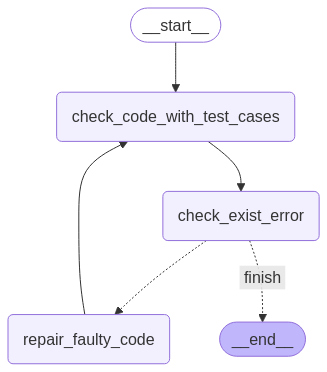

In [53]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [54]:
import signal

class TimeoutException(Exception):
    pass

def timeout_handler(signum, frame):
    raise TimeoutException("Code execution exceeded the timeout limit")

def run_with_timeout(timeout, func, *args, **kwargs):
    # Set the signal handler for the SIGALRM signal
    signal.signal(signal.SIGALRM, timeout_handler)
    # Set the alarm for the specified timeout
    signal.alarm(timeout)
    try:
        # Execute the function with the provided arguments
        result = func(*args, **kwargs)
    except TimeoutException as e:
        raise e
    finally:
        # Cancel the alarm
        signal.alarm(0)
    return result

In [55]:
if RUN_ON_WINDOWS:
    %pip install func_timeout

    import time
    from func_timeout import func_timeout, FunctionTimedOut


    def deff():
        import time
        time.sleep(10)
        return 'hi'

    try:
        result = func_timeout(5, deff, args=())
        print(result)
    except:
        print("Code execution exceeded the timeout limit")

    def run_with_timeout_win(timeout, func, *args):
        try:
            # Execute the function with the provided arguments
            result = func_timeout(timeout, func, args = (*args,))
            return result
        except:
            raise TimeoutException("Code execution exceeded the timeout limit")

In [56]:
COUNT_FIX_ERROR = 0
COUNT_FAULTY_CODE = 0

def log_to_file(filename, log_entry):
    """
    Append a dictionary log entry to a file.

    :param filename: Name of the file where the log should be written.
    :param log_entry: Dictionary containing the log entry.
    """
    with open(filename, 'a') as file:
        json_entry = json.dumps(log_entry)
        file.write(json_entry + '\n')


def find_and_store_paths(path):
    # Store single or duplicated files (find input/output test_case)
    dct_duplicated_file = collections.defaultdict(list)
    for fl in glob.glob(f"{path}/*"):
        tmp_fl = re.sub(r'(input)|(output)', '', fl)
        if tmp_fl in dct_duplicated_file['unique_files']:
            dct_duplicated_file['unique_files'].remove(tmp_fl)
            dct_duplicated_file['duplicate_files'].append(fl)
            fl = re.sub(r'\b(input|output)\b', lambda x: 'output' if x.group() == 'input' else 'input', fl)
            dct_duplicated_file['duplicate_files'].append(fl)
        elif not tmp_fl in dct_duplicated_file['unique_files']:
            dct_duplicated_file['unique_files'].append(tmp_fl)
    return dct_duplicated_file


def graph_invoke_with_timeout(graph, inputs):
    config_thread_id = {}
    if STORE_GRAPH_IN_MEMORY:
        thread_id = str(uuid.uuid4())
        config_thread_id = {"thread_id": thread_id}
    result = graph.invoke(inputs, config={**config_thread_id, "recursion_limit": 100})
    return result

def run_graph(graph, inputs):
    global COUNT_FIX_ERROR
    global COUNT_FAULTY_CODE
    dct_log = {
        'code_file_path' : (
            "/content/codeflaws" + inputs['code_file_path'].split("codeflaws")[-1]
            if RUN_ON_WINDOWS
            else inputs['code_file_path']
        ),
    }
    try:
        start_time = time.time()
        if RUN_ON_WINDOWS:
            result = run_with_timeout_win(60, graph_invoke_with_timeout, graph, inputs)
        else:
            result = run_with_timeout(600, graph_invoke_with_timeout, graph, inputs)
        end_time = time.time()
        dct_log = {
            **dct_log,
            'list_failed_test_cases_count': result['list_failed_test_cases_count'],
            'apply_sbfl': result['apply_sbfl'],
            'llm_model_name': inputs['llm_model_name'],
            'initial_failed_test_cases_count': result['initial_failed_test_cases_count'],
            'fail_test_cases': len(result['fail_test_cases']),
            'initial_code_have_error': result['initial_code_have_error'],
            'code_have_error': result['code_have_error'],
            'try_count': result['try_count'],
            'response_time': end_time - start_time,
            'generated_code': result.get('generated_code', ''),
            'log_execution': '\n'.join(result['log_execution']),
        }
        COUNT_FIX_ERROR += (result['try_count']>0) and (result['code_have_error']==False)
        COUNT_FAULTY_CODE += (result['try_count']>0)
    except Exception as e:
        dct_log = {
            **dct_log,
            'error': repr(e),
        }
        # The below line checks if the open-router API is not reachable, so we need to write it to the log file.
        if "'NoneType' object is not iterable" in dct_log.get('error', ""):
            print("open-router API is not reachable")
            return
    LLM_MODEL_NAME = inputs['llm_model_name']
    LLM_MODEL_NAME_SPLIT = LLM_MODEL_NAME.split('/')[-1] + ("-wo-testcases-exec" if WITHOUT_TESTCASES_EXEC else "")
    log_to_file(f"{PATH_FOR_RUNNING}/logfile-{LLM_MODEL_NAME_SPLIT}.txt", dct_log)

In [57]:
for _ in range(5):
    for folder in tqdm.tqdm(glob.glob(
        "/content/codeflaws/*"
    )):
        for LLM_MODEL_NAME in [
            "meta-llama/open-router-llama-3.1-70b-instruct:free",
            "meta-llama/open-router-llama-3.1-405b-instruct:free",
            "meta-llama/open-router-llama-3.2-90b-vision-instruct:free",
        ]:

            LLM_MODEL_NAME_SPLIT = LLM_MODEL_NAME.split('/')[-1] + ("-wo-testcases-exec" if WITHOUT_TESTCASES_EXEC else "")
            before_ask_files = []
            try:
                if CHECK_BEFORE_ASK:
                    file_path = f'{PATH_FOR_RUNNING}/logfile-{LLM_MODEL_NAME_SPLIT}.txt'
                    with open(file_path, 'r') as file:
                        for line in file:
                            line = line.strip()
                            try:
                                dictionary = json.loads(line)
                                if isinstance(dictionary, dict):  # Ensure it's actually a dictionary
                                    before_ask_files.append(dictionary['code_file_path'])
                            except (ValueError, SyntaxError) as e:
                                pass
            except:
                pass
            print(LLM_MODEL_NAME_SPLIT)
            print(len(before_ask_files))


            global COUNT_FIX_ERROR
            global COUNT_FAULTY_CODE
            dct_paths = find_and_store_paths(path=folder)
            # Get code_file and compile. Input test case and get result
            for fl_path in dct_paths['unique_files']:
                fl_path_win2colab = ""
                if RUN_ON_WINDOWS:
                    fl_path = '/'.join(fl_path.split('\\'))
                    fl_path_win2colab = "/content/codeflaws" + fl_path.split("codeflaws")[-1]
                if (fl_path.endswith('.c') and
                    (
                        fl_path not in before_ask_files and
                        fl_path_win2colab not in before_ask_files
                    )
                ):
                        print(fl_path)
                        inputs = {
                            "list_failed_test_cases_count": [],
                            "llm_model_name": LLM_MODEL_NAME,
                            "code_file_path": fl_path,
                            "test_case_paths": dct_paths["duplicate_files"],
                            "apply_sbfl": APPLY_SBFL,
                            "sbfl_formula": "Ochiai",
                            "sbfl_likelihood": 0.5,
                            "max_try_count": 2,
                            "try_count": 0,
                            "messages": []
                        }
                        run_graph(graph, inputs)
            try:
                print(f"{(COUNT_FIX_ERROR / COUNT_FAULTY_CODE)*100} %")
            except:
                pass
            if not COUNT_FAULTY_CODE % 10:
                clear_output()

  0%|          | 1/3908 [01:16<83:06:47, 76.58s/it]

open-router-llama-3.1-70b-instruct:free-wo-testcases-exec
2
/content/codeflaws/14-B-bug-9606134-9606175/14-B-9606134.c
Try 3, With meta-llama/llama-3.1-70b-instruct:free, By api_keys_1
api_keys_1


  0%|          | 1/3908 [01:24<91:51:44, 84.64s/it]


KeyboardInterrupt: 